train ve validation icin higgs datasindan veri uretme

In [1]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zz5u67nq
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-zz5u67nq
  Resolved https://github.com/tensorflow/docs to commit 45a981f5c06b972e669fd7aa25f94511b47acdae
  Preparing metadata (setup.py) ... done
  Using cached astor-0.8.1-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached fastjsonschema-2.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux

2024-09-07 20:44:55.740150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


In [2]:
#bu kisim ne icin hicbir fikrim yok...
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

  12427264/2816407858 [..............................] - ETA: 2:05:55

KeyboardInterrupt: 

In [3]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")
#gzip dosyasini acmaya gerek olmadan isleyebiliyoruz

NameError: name 'gz' is not defined

In [ ]:
#scalar --> (feture vector, label)
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [ ]:
packed_ds = ds.batch(10000).map(pack_row).unbatch() #train+validation

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)
tf.Tensor(
[ 0.5343866  -0.6691707  -0.6921558   0.99057907  0.30910575  0.90581214
  0.14355789 -1.3254559   0.          1.3717185   0.5080887   0.58302563
  2.2148721   0.9225389   0.809384   -0.90275425  0.          1.3820658
  0.13112538  1.1890152   3.1019614   0.8751621   0.9890183   0.9872681
  1.4120023   0.68470424  1.0086048   1.1116836 ], shape=(28,), dtype=float32)


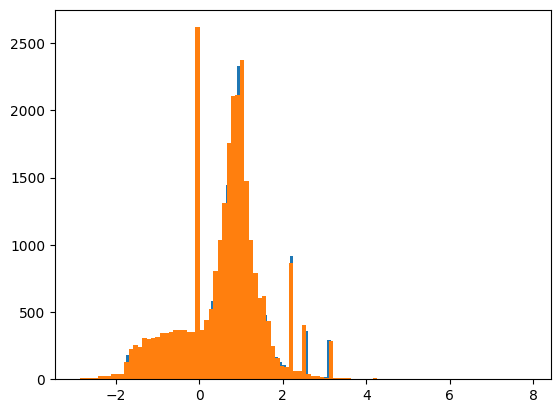

In [ ]:
for features,label in packed_ds.batch(1000).take(2):#1000 elemanli 2 ornek data
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [ ]:
#validation --> 1000
#training --> 10000
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [ ]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
#cache() her seferınde verıyı tekrar okumamıza gerek kalmamasını saglıyor

In [ ]:
train_ds #burada ne tarz bir dataset elde ettigimizi anlayamadim

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
validate_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
#batch_size her bir gradient descent isleminden once loss hesaplamak icin kullanilan data miktarini mi belirliyor
#batch in icindeki her bir data uzerinden total loss hesaplayip parametreleri bu lossa gore update ederek sonraki batch e gecme seklide bir mantik mi var?

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
validate_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

overfitting

'Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers`.schedules to reduce the learning rate over time'

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

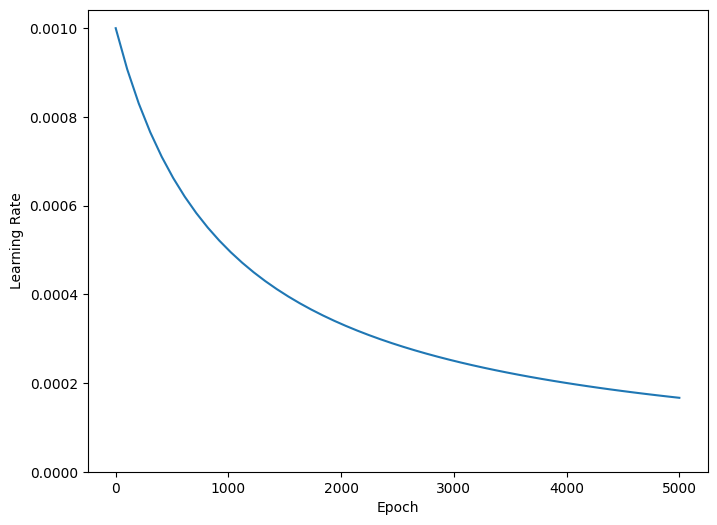

In [ ]:
#learning rate:
#1000 epochs --> x1/2
#2000 epochs --> x1/3 ...
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
#gereksiz uzun train sürelerinden kaçınmak için
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])
  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

loss functıonlarla ilgili soru: image classification örneğinde de SparseCategoricalCrossentropy isminde bir loss function tanımlıyorduk burada da BinaryCrossentropy kullanılmış Mean squared ya da Mean Absolute error bana bir önceki periyodda mantıklı gelmişti ama crossentropy nin altında nasıl bir mantık var anlayamadım.

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [ ]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')
#burada train_ds ya da validate_ds le ilgili bi hata alıyorum ama sebebini çözemedim.
# --> Received: target.shape=(None,), output.shape=(None, 1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

hatayı çözemediğim için ilerleyemedim